In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/AI ML Projects/Axix/Walmart_Sales.csv")


In [7]:
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   i

In [8]:
from datetime import date
#convert date into proper format
df['Date']=pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)



## **Aggregate Data**

In [9]:
df['Store'].unique()
store_sales = df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
store1=store_sales[store_sales['Store']==1]
store1 = store1.set_index('Date')


## Visualization of data

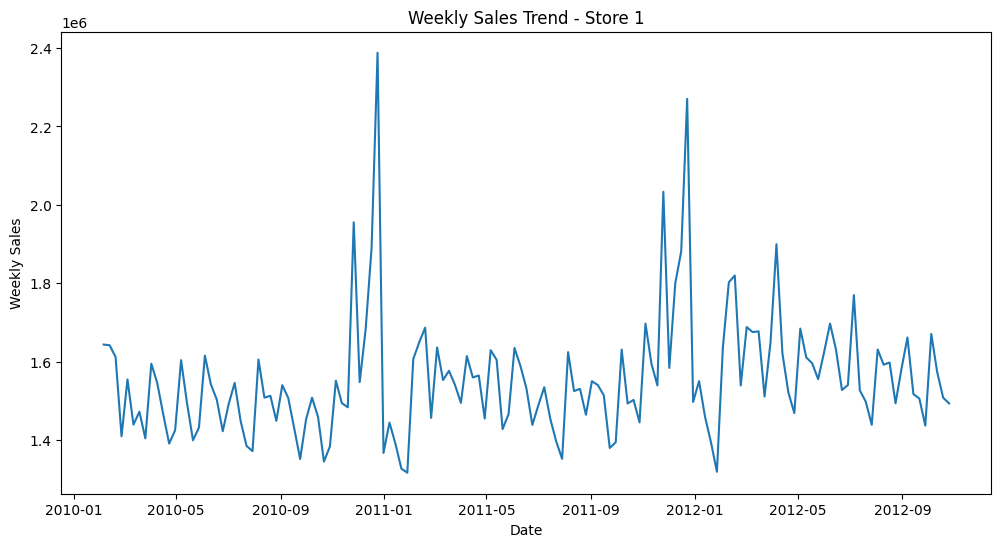

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(store1.index, store1['Weekly_Sales'])
plt.title("Weekly Sales Trend - Store 1")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

In [18]:
# convert to datetime (your dates look like dd-mm-YYYY so use dayfirst=True)
store1.index = pd.to_datetime(store1.index, dayfirst=True)

# ensure sorted index
store1 = store1.sort_index()

# (optional) set a weekly frequency so missing weeks become explicit
ts = store1['Weekly_Sales'].fillna(0)



In [19]:
# look for missing values after asfreq
print(store1['Weekly_Sales'].isnull().sum())

# simple fill: linear interpolate for small gaps
store1['Weekly_Sales'] = store1['Weekly_Sales'].interpolate()

# optional: cap or remove obvious outliers (holidays spikes)
# You can inspect values > some threshold:
store1[store1['Weekly_Sales'] > store1['Weekly_Sales'].quantile(0.99)]


142


,Store,Weekly_Sales
Date,,


In [23]:
# Step 1: Group sales by Store + Date
store_sales = df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

# Step 2: Filter for Store 1
store1 = store_sales[store_sales['Store'] == 1]

# Step 3: Convert Date to datetime
store1['Date'] = pd.to_datetime(store1['Date'], dayfirst=True)

# Step 4: Set Date as index
store1 = store1.set_index('Date')

# Step 5: Resample to weekly sales (this avoids NaNs / constant issues)
ts = store1['Weekly_Sales'].resample('W').sum()

# Step 6: Train/test split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Quick check
print(train.head(), "\n")
print(train.tail())


Date
2010-02-07    1643690.90
2010-02-14    1641957.44
2010-02-21    1611968.17
2010-02-28    1409727.59
2010-03-07    1554806.68
Freq: W-SUN, Name: Weekly_Sales, dtype: float64 

Date
2012-03-11    1675431.16
2012-03-18    1677472.78
2012-03-25    1511068.07
2012-04-01    1649604.63
2012-04-08    1899676.88
Freq: W-SUN, Name: Weekly_Sales, dtype: float64


/tmp/ipython-input-2675334252.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1['Date'] = pd.to_datetime(store1['Date'], dayfirst=True)


In [24]:
from statsmodels.tsa.stattools import adfuller
res = adfuller(train)
print("ADF statistic:", res[0], "p-value:", res[1])


ADF statistic: -4.558244931268866 p-value: 0.00015410217261593956


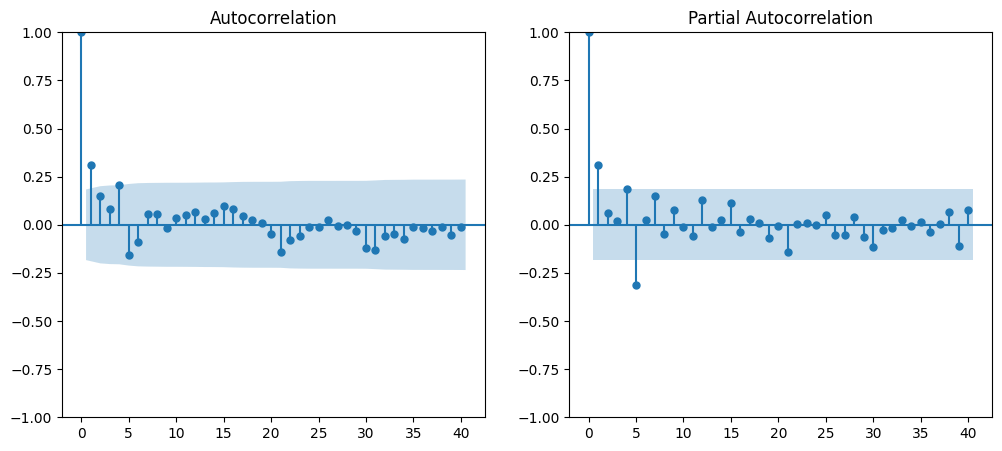

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(train, lags=40, ax=plt.gca())
plt.subplot(122)
plot_pacf(train, lags=40, ax=plt.gca())
plt.show()


In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 0, 1))   # here p=1, d=0, q=1
res = model.fit()
print(res.summary())

fc = res.forecast(steps=len(test))


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1527.927
Date:                Fri, 19 Sep 2025   AIC                           3063.855
Time:                        15:21:28   BIC                           3074.799
Sample:                    02-07-2010   HQIC                          3068.296
                         - 04-08-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.551e+06   2.98e+04     51.994      0.000    1.49e+06    1.61e+06
ar.L1          0.5372      0.320      1.680      0.093      -0.089       1.164
ma.L1         -0.2452      0.375     -0.653      0.5

## SARIMA

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -772.007
Date:                            Fri, 19 Sep 2025   AIC                           1554.015
Time:                                    15:32:20   BIC                           1564.569
Sample:                                02-07-2010   HQIC                          1558.151
                                     - 04-08-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2091      0.575      0.364      0.716      -0.917       1.335
ma.L1         -0.3387      0.566   

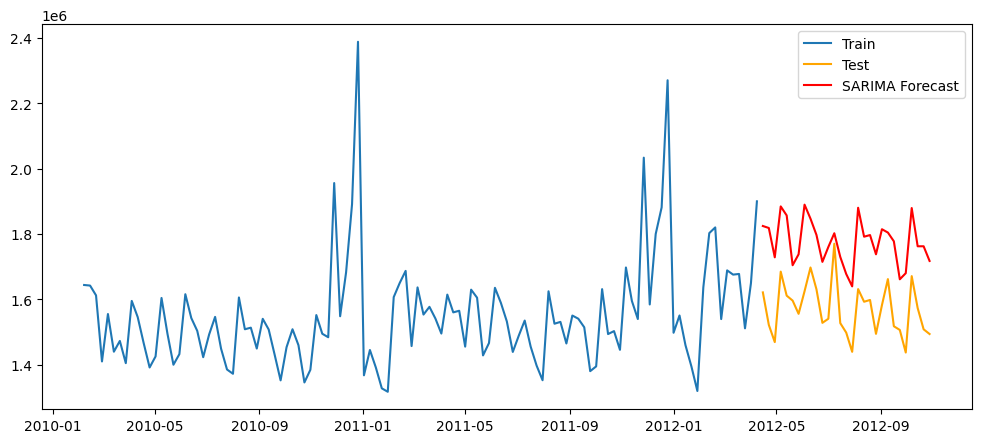

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Fit SARIMA model
# Example parameters (you will adjust later)
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52))
sarima_res = sarima_model.fit()

# Model summary
print(sarima_res.summary())

# Forecast
sarima_forecast = sarima_res.forecast(steps=len(test))

# Plot actual vs forecast
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red')
plt.legend()
plt.show()


## LSTM Implementation

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0546
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0368
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0275
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0292
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0199
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0174
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0224
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0239
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0196
Epoch 16/20
14/14 

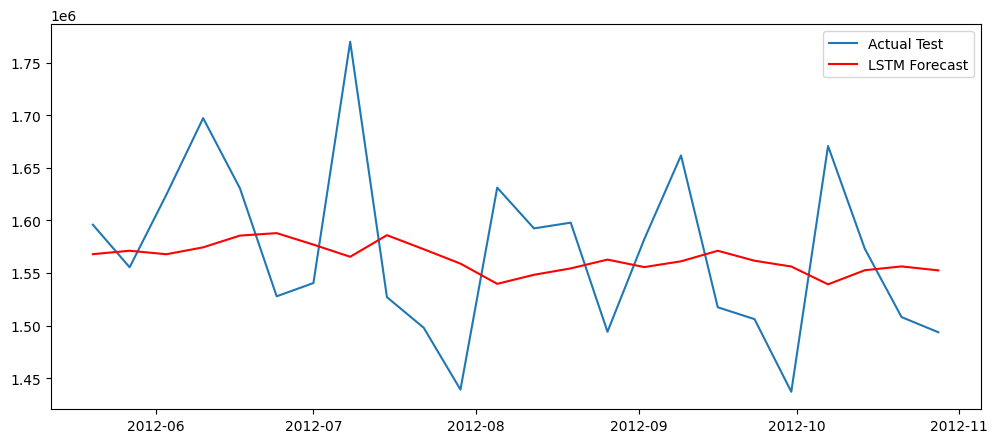

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale the data (neural nets work better on 0–1 scale)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))

# Create sequences for LSTM
def create_sequences(data, seq_length=5):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, seq_length=5)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)

# Forecast
test_scaled = scaler.transform(test.values.reshape(-1,1))
X_test, y_test = create_sequences(test_scaled, seq_length=5)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot
plt.figure(figsize=(12,5))
plt.plot(test.index[5:], test.values[5:], label="Actual Test")
plt.plot(test.index[5:], predictions, label="LSTM Forecast", color='red')
plt.legend()
plt.show()


## FB Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjwwjx5ou/fuw04zeh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjwwjx5ou/l12czts0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81208', 'data', 'file=/tmp/tmpjwwjx5ou/fuw04zeh.json', 'init=/tmp/tmpjwwjx5ou/l12czts0.json', 'output', 'file=/tmp/tmpjwwjx5ou/prophet_model8uq1q7kx/prophet_model-20250919153847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


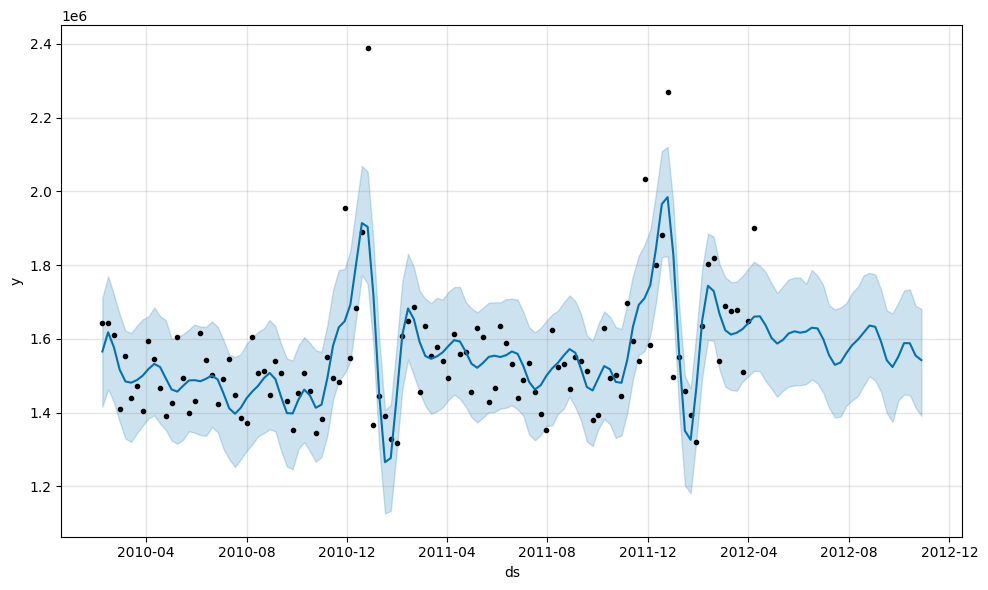

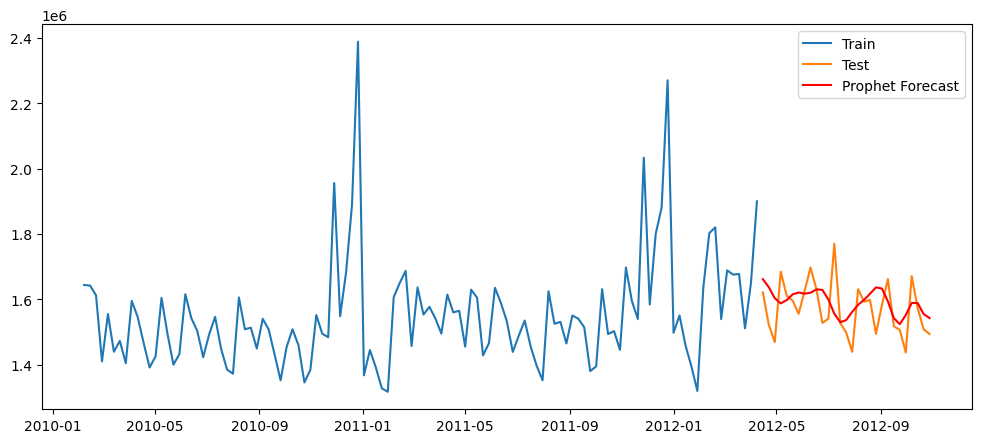

In [30]:
from prophet import Prophet

# Prepare data for Prophet
df = train.reset_index()
df.columns = ['ds','y']   # Prophet requires these names

# Initialize and fit model
prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet.fit(df)

# Forecast future
future = prophet.make_future_dataframe(periods=len(test), freq='W')
forecast = prophet.predict(future)

# Plot forecast
fig1 = prophet.plot(forecast)
plt.show()

# Compare actual vs forecast
forecast_test = forecast.set_index('ds').loc[test.index]['yhat']

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast_test, label="Prophet Forecast", color='red')
plt.legend()
plt.show()
